# Improved LSTM for NSL-KDD (Binary Classification)

This notebook trains an **Improved LSTM** model for intrusion detection on the **NSL-KDD** dataset.

**Goal**: Achieve high accuracy in distinguishing **Normal** traffic from **Attacks**.

**Key Features:**
- **Bidirectional LSTM**: Captures context from both directions.
- **Dropout & Batch Norm**: Regularization to prevent overfitting.
- **Class Weights**: Handles class imbalance in the training set.

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
sys.path.append(str(Path("../../").resolve()))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sns.set_theme(style="whitegrid")
torch.manual_seed(42)
np.random.seed(42)

In [2]:
CONFIG = {
    "batch_size": 1024,
    "epochs": 50,
    "learning_rate": 0.001,
    "weight_decay": 1e-5,
    "hidden_dim": 256,
    "num_layers": 3,
    "dropout": 0.3,
    "patience": 10,
}

COLUMNS = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level'
]

ATTACK_MAPPING = {
    'normal': 0,
    'back': 1, 'land': 1, 'neptune': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,
    'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1,
    'ipsweep': 1, 'nmap': 1, 'portsweep': 1, 'satan': 1, 'mscan': 1, 'saint': 1,
    'ftp_write': 1, 'guess_passwd': 1, 'imap': 1, 'multihop': 1, 'phf': 1,
    'spy': 1, 'warezclient': 1, 'warezmaster': 1, 'sendmail': 1, 'named': 1,
    'snmpgetattack': 1, 'snmpguess': 1, 'xlock': 1, 'xsnoop': 1, 'worm': 1,
    'buffer_overflow': 1, 'loadmodule': 1, 'perl': 1, 'rootkit': 1,
    'httptunnel': 1, 'ps': 1, 'sqlattack': 1, 'xterm': 1,
}

DATA_PATH = Path("../../data/raw/nsl-kdd")

def load_nsl_kdd(filepath, scaler=None, label_encoders=None, fit=True):
    df = pd.read_csv(filepath, header=None, names=COLUMNS)
    print(f"Loaded {len(df):,} samples from {filepath.name}")
    
    df = df.drop('difficulty_level', axis=1)
    df['label'] = df['label'].map(lambda x: ATTACK_MAPPING.get(x, 1))
    
    X = df.drop('label', axis=1)
    y = df['label'].values
    
    cat_cols = ['protocol_type', 'service', 'flag']
    if fit:
        label_encoders = {}
        for col in cat_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
    else:
        for col in cat_cols:
            X[col] = X[col].apply(lambda x: x if x in label_encoders[col].classes_ else 'unknown')
            if 'unknown' not in label_encoders[col].classes_:
                label_encoders[col].classes_ = np.append(label_encoders[col].classes_, 'unknown')
            X[col] = label_encoders[col].transform(X[col].astype(str))
            
    X = X.values.astype(np.float32)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    if fit:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
        
    return X, y, scaler, label_encoders

In [3]:
try:
    X_train, y_train, scaler, label_encoders = load_nsl_kdd(
        DATA_PATH / "train.txt", fit=True
    )
    
    X_test, y_test, _, _ = load_nsl_kdd(
        DATA_PATH / "test.txt", 
        scaler=scaler, label_encoders=label_encoders, fit=False
    )
    
    val_size = int(0.1 * len(X_train))
    indices = np.random.permutation(len(X_train))
    
    X_val = X_train[indices[:val_size]]
    y_val = y_train[indices[:val_size]]
    X_train = X_train[indices[val_size:]]
    y_train = y_train[indices[val_size:]]
    
    print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
    
except FileNotFoundError:
    print("❌ Dataset not found!")

Loaded 125,973 samples from train.txt
Loaded 22,544 samples from test.txt
Train: (113376, 41), Val: (12597, 41), Test: (22544, 41)


## 2. LSTM Model Definition

In [4]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=2, hidden_dim=256, num_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()
        self.num_directions = 2 if bidirectional else 1
        
        self.input_bn = nn.BatchNorm1d(input_dim)
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(hidden_dim * self.num_directions),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * self.num_directions, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout * 0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.input_bn(x)
        x = self.input_fc(x)
        x = torch.relu(x)
        
        x = x.unsqueeze(1) # (batch, 1, hidden)
        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :] # Last hidden state
        
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if 'X_train' in globals():
    model = LSTMClassifier(
        input_dim=X_train.shape[1],
        hidden_dim=CONFIG["hidden_dim"],
        num_layers=CONFIG["num_layers"],
        dropout=CONFIG["dropout"]
    ).to(device)
    print(f"Model on {device}")

Model on cuda


In [5]:
if 'X_train' in globals():
    # Loss with Class Weights
    class_counts = np.bincount(y_train)
    class_weights = torch.FloatTensor(len(y_train) / (2 * class_counts)).to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    
    # DataLoaders
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), 
        batch_size=CONFIG["batch_size"], shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val)), 
        batch_size=CONFIG["batch_size"], shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), 
        batch_size=CONFIG["batch_size"], shuffle=False
    )

c:\Users\musab\Projects\NIDS-DL\venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [6]:
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += y_batch.size(0)
        correct += pred.eq(y_batch).sum().item()
    return total_loss/len(loader), correct/total

def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item()
            _, pred = outputs.max(1)
            total += y_batch.size(0)
            correct += pred.eq(y_batch).sum().item()
    return total_loss/len(loader), correct/total

In [7]:
if 'X_train' in globals():
    best_val_acc = 0
    
    for epoch in range(CONFIG["epochs"]):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer)
        val_loss, val_acc = evaluate(model, val_loader)
        
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "../../results/models/best_lstm_kdd.pt")
            
        if (epoch+1) % 5 == 0:
            print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

Epoch 5 | Train Acc: 0.9925 | Val Acc: 0.9925
Epoch 10 | Train Acc: 0.9943 | Val Acc: 0.9936
Epoch 15 | Train Acc: 0.9956 | Val Acc: 0.9945
Epoch 20 | Train Acc: 0.9958 | Val Acc: 0.9931
Epoch 25 | Train Acc: 0.9963 | Val Acc: 0.9956
Epoch 30 | Train Acc: 0.9965 | Val Acc: 0.9952
Epoch 35 | Train Acc: 0.9967 | Val Acc: 0.9951
Epoch 40 | Train Acc: 0.9969 | Val Acc: 0.9958
Epoch 45 | Train Acc: 0.9967 | Val Acc: 0.9956
Epoch 50 | Train Acc: 0.9969 | Val Acc: 0.9954


C:\Users\musab\AppData\Local\Temp\ipykernel_69268\3461889806.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../../results/models/best_

Test Accuracy: 0.7992
              precision    recall  f1-score   support

      Normal       0.69      0.98      0.81      9711
      Attack       0.97      0.67      0.79     12833

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.80     22544



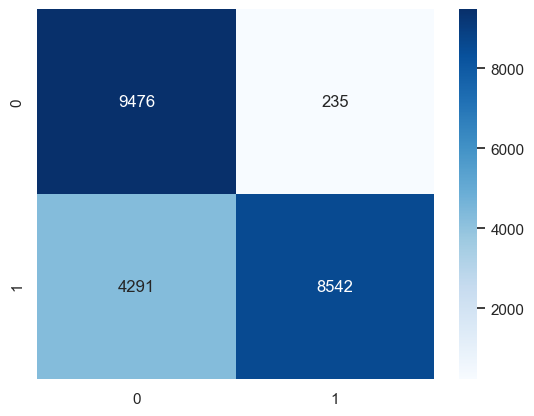

4158

In [8]:
if 'X_train' in globals():
    model.load_state_dict(torch.load("../../results/models/best_lstm_kdd.pt"))
    test_loss, test_acc = evaluate(model, test_loader)
    print(f"Test Accuracy: {test_acc:.4f}")
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            _, pred = outputs.max(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y_batch.numpy())
            
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Attack']))
    sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues')
    plt.show()

#Cleanup
torch.cuda.empty_cache()
import gc
gc.collect()